# Test - Data Science - BNDMR

Ce test fut réalisé sous Python par l'importation des tables en format csv. Voir le code R pour l'export des données. 

## Contexte

Dans le cadre d'une demande de la filière **FIMARAD** pour une étude approfondie de l'*épidermolyse* *bulleuse* (EB), une malade dermatologique rare, nous réaliserons une étude démographique. D’apres la nomenclature Orphanet des maladies rares, l'*EB* se distingue en 2 catégories et sous-catégories : 
- *épidermolyse* *bulleuse* *simple*, noté 304 :
  - *épidermolyse* *bulleuse* *simple* *avec* *atrésie* *du* *pylore*, noté 158684;
  - *épidermolyse* *bulleuse* *simple* *avec* *dystrophie* *musculaire*, noté 257;
- *épidermolyse* *bulleuse* *jonctionnelle*, noté 305 :
  - *épidermolyse* *bulleuse* *jonctionnelle* *avec* *atrésie* *pylorique*, noté 79403;
  - *épidermolyse* *bulleuse* *jonctionnelle* *localisée*, noté 251393;

## Objectif

Dans cette étude, nous nous intéresserons à :
- étudier les données sur les patients hospitalisées pour l'*EB*;
- évaluer l'impact du type *EB* sur l'évolution de la concentration de plomb chez les patients traités avec le même médicaments

## Exploration des données

### Présentation des tables

Pour réaliser notre étude, la filière nous a confiée trois tables : 
- *patients* : données démographiques des patients 
- *diagnostics* : données sur les diagnostics des patients
- *obs_plomb* : données sur l'état des patients traités par le plomb durant 6 semaines

#### Import des librairies

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ignorer les avertissements
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
patients = pd.read_csv("patients.csv")
diagnostics = pd.read_csv("diagnostics.csv")
obs_plomb = pd.read_csv("obs_plomb.csv")

In [4]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   birthyear   184 non-null    int64  
 1   housenum    183 non-null    float64
 2   streetname  184 non-null    object 
 3   idmr        184 non-null    int64  
 4   alive       184 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 7.3+ KB


In [5]:
obs_plomb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   idmr    100 non-null    int64  
 1   W0      100 non-null    float64
 2   W1      100 non-null    float64
 3   W4      100 non-null    float64
 4   W6      100 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 4.0 KB


In [6]:
diagnostics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   idmr           162 non-null    int64 
 1   diagnostic     162 non-null    int64 
 2   level          124 non-null    object
 3   inclusion      162 non-null    object
 4   last_activity  162 non-null    object
dtypes: int64(2), object(3)
memory usage: 6.5+ KB


In [7]:
patients.shape

(184, 5)

In [8]:
diagnostics.shape

(162, 5)

In [9]:
obs_plomb.shape

(100, 5)

#### Description des tables

La table *patients* possède les variable suivantes :
- *birthyear* : année de naissance du patient;
- *housenum* : numéro de la maison du patient;
- *streetname* : nom de la rue du patient;
- *idmr* : identifiant du patient;
- *alive* : statut vital du patient;

La table *diagnostics* possède les variables suivantes :
- *idmr* : identifiant du patient;
- *diagnostics* : type de *EB* atteint par le patient;
- *level*
- *inclusion* : date de début de l'hospitalisation du patient;
- *last_activity* : dernière date de l'activité du patient;

La table *obs_plomb* possède les variables suivants :
- *idmr* : identifiant du patient;
- *WO* : pas de traitement
- *W1* : première semaine du traitement de plomb
- *W4* : quatrième semaine du traitement de plomb
- *W6* : dernière semaine du traitement de plomb

On remarque que les tables n'ont pas le même nombre d'observations. Dans toutes les tables, on retrouve une variable commune *idmr*, l'identifiant des patients. 

#### Données démographiques sur les patients hospitaliéses pour l'EB

In [10]:
# Utilisation de la fonction merge pour effectuer la jointure
patients_EB = pd.merge(patients, diagnostics, on='idmr', how='left')

In [11]:
patients_EB.head()

,birthyear,housenum,streetname,idmr,alive,diagnostic,level,inclusion,last_activity
0,1957,1564.0,fairview ct,3263373164,1,251393.0,CON,2017-06-14,2019-02-25
1,1971,6909.0,shepherd ave apt 4,3433643965,1,251393.0,UNK,2019-06-18,2020-04-09
2,1971,6909.0,shepherd ave apt 4,3433643965,1,305.0,UNK,2019-06-18,2020-04-09
3,1948,4547.0,piedmont ave,3335356165,1,257.0,PRO,2019-07-21,2021-04-01
4,1961,30436.0,49th ave,6136353339,1,79403.0,NaN,2019-05-10,2021-09-27


#### Nettoyage des données

On commence par supprimer toutes les valeurs manquantes. 

In [12]:
# Vérification des valeurs manquantes
patients_EB.isnull().any()

birthyear        False
housenum          True
streetname       False
idmr             False
alive            False
diagnostic        True
level             True
inclusion         True
last_activity     True
dtype: bool

In [13]:
# Nombre de valeurs pour chaque variable
patients_EB.isnull().sum()

birthyear         0
housenum          1
streetname        0
idmr              0
alive             0
diagnostic       23
level            63
inclusion        23
last_activity    23
dtype: int64

In [14]:
# Identifier les lignes avec des valeurs manquantes
rows_with_missing_values = patients_EB[patients_EB[['diagnostic', 'inclusion', 'last_activity']].isnull().any(axis=1)]
print(rows_with_missing_values.head(10))

# Nombre de valeur manquante
print(rows_with_missing_values.isnull().sum())

# Récupérez les ensembles d'identifiants des deux DataFrames
identifiers1 = set(rows_with_missing_values['idmr'])
identifiers2 = set(diagnostics['idmr'])

# Vérifiez si tous les identifiants de la base de données 1 sont présents dans la base de données 2
if identifiers1.issubset(identifiers2):
    print("Tous les identifiants de la table sont présents dans la table diagnostics.")
else:
    print("Certains identifiants de la table ne sont pas présents dans la table diagnostics.")

    birthyear  housenum                  streetname        idmr  alive  \
12       1972    1470.0                   james ave  3438626264      1   
30       1995   16665.0                    buren pl  3634636631      1   
34       1995    3294.0           deauville park ct  6466633635      1   
45       1941    3332.0                altamont ave  3830336666      1   
46       1936    6029.0                   clarke st  6531336463      1   
48       1986    3646.0                longridge rd  3932383061      0   
67       1981    1841.0   alvarado niles rd apt 211  6638373736      1   
80       1971    6378.0           central ave apt d  6533393465      1   
89       1918    5943.0                 san luis rd  3537363332      1   
92       1969    3623.0           prospect st apt c  6565643439      1   

    diagnostic level inclusion last_activity  
12         NaN   NaN       NaN           NaN  
30         NaN   NaN       NaN           NaN  
34         NaN   NaN       NaN           NaN

On constate qu'on a des valeurs manquantes suite à notre jointure. Cela s'expliquer par le fait que tout les patients ne sont atteints de l'*EB*. En tout, 23 patients n'en souffrent pas. 

In [15]:
# Supprimer les lignes avec des valeurs manquantes dans la colonne 'diagnostics'
patients_EB = patients_EB.dropna(subset=['diagnostic'])

In [16]:
patients_EB.isnull().sum()

birthyear         0
housenum          1
streetname        0
idmr              0
alive             0
diagnostic        0
level            40
inclusion         0
last_activity     0
dtype: int64

In [17]:
# Identifier les lignes avec des valeurs manquantes dans la variable catégorielle 'level'
rows_with_missing_values = patients_EB[patients_EB['level'].isnull()]

# Compter le nombre de chaque modalité de 'diagnostic' pour les lignes avec des valeurs manquantes dans 'level'
modalities_counts = rows_with_missing_values['diagnostic'].value_counts()

# Afficher les pourcentages
print("Pourcentage de chaque modalité de diagnostics associée à une valeur manquante dans level :")
print(modalities_counts)

Pourcentage de chaque modalité de diagnostics associée à une valeur manquante dans level :
diagnostic
79403.0     9
305.0       8
251393.0    7
304.0       6
257.0       6
158684.0    4
Name: count, dtype: int64


In [18]:
# Supprimer les lignes avec des valeurs manquantes dans les colonnes 'level' et 'housenum'
patients_EB = patients_EB.dropna(subset=['level', 'housenum'])

In [19]:
patients_EB.isnull().sum()

birthyear        0
housenum         0
streetname       0
idmr             0
alive            0
diagnostic       0
level            0
inclusion        0
last_activity    0
dtype: int64

On enchaîne par le traitement des doublons. Nous nous focaliserons uniquement sur la variable "idmr" pour cela. En effet, si deux patients ont le même identifiant, cela risque d'être problématique.

In [20]:
patients_EB[patients_EB.duplicated(subset=['idmr'], keep=False)]

,birthyear,housenum,streetname,idmr,alive,diagnostic,level,inclusion,last_activity
1,1971,6909.0,shepherd ave apt 4,3433643965,1,251393.0,UNK,2019-06-18,2020-04-09
2,1971,6909.0,shepherd ave apt 4,3433643965,1,305.0,UNK,2019-06-18,2020-04-09


On constate que l'on a un seul doublon. La différence réside dans le diagnostics. Il s'avère que le patient est atteint du *EB jonctionnelle*, plus précisément du *épidermolyse bulleuse jonctionnelle*. On va donc se focaliser uniquement sur la première variable qui est plus précise.

In [21]:
patients_EB = patients_EB.drop_duplicates(subset=['idmr'], keep='first')

In [22]:
# Rendre les variables 'alive' et 'diagnostic' catégorielle
patients_EB[['alive', 'diagnostic']] = patients_EB[['alive', 'diagnostic']].astype('category')

Commençons la création de nouvelles variables. Selon la nomenclature, il existe des catégories et des sous-catégories de l'*EB*.

In [23]:
# Utilisez des conditions booléennes et des expressions conditionnelles pour créer la nouvelle variable 'categorie'
# Définir les catégories en fonction de 'diagnostic'
patients_EB['catégorie'] = np.select(
    [patients_EB['diagnostic'].isin([251393, 79403, 305]),
     patients_EB['diagnostic'].isin([158684, 257, 304])],
    ['EB jonc', 'EB simple'],
    default='Aucun'
)

In [24]:
# Définir les sous-catégories en fonction de 'diagnostic'
patients_EB['sous-catégorie'] = np.select(
    [patients_EB['diagnostic'] == 251393,
     patients_EB['diagnostic'] == 79403,
     patients_EB['diagnostic'] == 305,
     patients_EB['diagnostic'] == 158684,
     patients_EB['diagnostic'] == 257,
     patients_EB['diagnostic'] == 304],
    ['EB jonc atresie pylorique', 'EB jonc localise', 'EB jonc non identifié', 'EB simple atresie pylorique', 'EB simple dysotrophie', 'EB simple non identifié'],
    default='Pas de sous-catégorie'
)

In [25]:
# Convertir les variables de date au format datetime
patients_EB['inclusion'] = pd.to_datetime(patients_EB['inclusion'])
patients_EB['last_activity'] = pd.to_datetime(patients_EB['last_activity'])

# Soustraire les deux dates pour obtenir la différence en jours
patients_EB['durée'] = (patients_EB['inclusion'] - patients_EB['last_activity']).dt.days
patients_EB['durée'] = patients_EB['durée']*(-1)

In [26]:
# Extraire l'année d'inclusion
year_inclusion = patients_EB['inclusion'].dt.year

# Calculer l'âge des patients au moment de leur inclusion
patients_EB['age_inclusion'] = year_inclusion - patients_EB['birthyear']

In [27]:
# Extraire l'année de la dernière activité
year_last_activity = patients_EB['last_activity'].dt.year

# Calculer l'âge des patients au moment de leur inclusion
patients_EB['age_last_activity'] = year_last_activity - patients_EB['birthyear']

In [28]:
# Combinez les deux variables pour former une adresse complète
patients_EB['adress'] = patients_EB['housenum'].astype(str) + ' ' + patients_EB['streetname']

In [29]:
patients_EB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 184
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   birthyear          122 non-null    int64         
 1   housenum           122 non-null    float64       
 2   streetname         122 non-null    object        
 3   idmr               122 non-null    int64         
 4   alive              122 non-null    category      
 5   diagnostic         122 non-null    category      
 6   level              122 non-null    object        
 7   inclusion          122 non-null    datetime64[ns]
 8   last_activity      122 non-null    datetime64[ns]
 9   catégorie          122 non-null    object        
 10  sous-catégorie     122 non-null    object        
 11  durée              122 non-null    int64         
 12  age_inclusion      122 non-null    int64         
 13  age_last_activity  122 non-null    int64         
 14  adress         

#### Données sur les patients atteints de l'EB traités par le plomb

In [30]:
# Utilisation de la fonction merge pour effectuer la jointure
patients_EB_plomb = pd.merge(patients_EB, obs_plomb, on='idmr', how='left')

#### Nettoyage des données

Dans cette partie, nous nous concentrerons uniquement sur la suppression des valeurs manquantes et des doublons.

In [31]:
# Vérification des valeurs manquantes
print(patients_EB_plomb.isnull().any())

# Supprimer les lignes avec des valeurs manquantes dans la colonne 'diagnostics'
patients_EB_plomb = patients_EB_plomb.dropna(subset=['W0'])

birthyear            False
housenum             False
streetname           False
idmr                 False
alive                False
diagnostic           False
level                False
inclusion            False
last_activity        False
catégorie            False
sous-catégorie       False
durée                False
age_inclusion        False
age_last_activity    False
adress               False
W0                    True
W1                    True
W4                    True
W6                    True
dtype: bool


In [32]:
print("Il y a ", patients_EB.shape[0]-patients_EB_plomb.shape[0], "qui ne sont pas traités par le plomb.")

Il y a  42 qui ne sont pas traités par le plomb.


In [33]:
patients_EB_plomb[patients_EB_plomb.duplicated(subset=['idmr'], keep=False)]

,birthyear,housenum,streetname,idmr,alive,diagnostic,level,inclusion,last_activity,catégorie,sous-catégorie,durée,age_inclusion,age_last_activity,adress,W0,W1,W4,W6
1,1971,6909.0,shepherd ave apt 4,3433643965,1,251393.0,UNK,2019-06-18,2020-04-09,EB jonc,EB jonc atresie pylorique,296,48,49,6909.0 shepherd ave apt 4,28.5,32.6,27.5,22.8
2,1971,6909.0,shepherd ave apt 4,3433643965,1,251393.0,UNK,2019-06-18,2020-04-09,EB jonc,EB jonc atresie pylorique,296,48,49,6909.0 shepherd ave apt 4,29.4,22.1,25.3,4.1


In [34]:
patients_EB_plomb = patients_EB_plomb.drop_duplicates(subset=['idmr'], keep='first')

#### Analyse des données démographiques des patients hospitalisés pour l'*EB*

##### Analyse sur le diagnostic

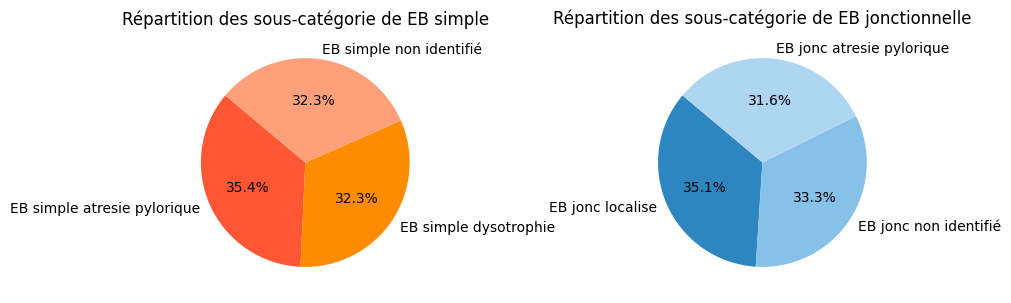

In [35]:
# Palette de couleurs personnalisée
custom_colors = ['#FF5733', '#FF8C00', '#FFA07A', '#FF6347', '#FF4500']
custom_colors2 = ['#2E86C1', '#85C1E9', '#AED6F1', '#D6EAF8', '#EBF5FB']

# Compter le nombre d'occurrences de chaque modalité selon chaque catégorie
modalites_counts_simple = patients_EB.loc[patients_EB['catégorie'] == "EB simple"]['sous-catégorie'].value_counts()
modalites_counts_jonc = patients_EB.loc[patients_EB['catégorie'] == "EB jonc"]['sous-catégorie'].value_counts()

# Créer une figure et deux sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Premier diagramme circulaire
axs[0].pie(modalites_counts_simple, labels=modalites_counts_simple.index, autopct='%1.1f%%', startangle=140, colors = custom_colors)
axs[0].set_title('Répartition des sous-catégorie de EB simple')

# Deuxième diagramme circulaire
axs[1].pie(modalites_counts_jonc, labels=modalites_counts_jonc.index, autopct='%1.1f%%', startangle=140, colors = custom_colors2)
axs[1].set_title('Répartition des sous-catégorie de EB jonctionnelle')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher les diagrammes circulaires
plt.show()

##### Analyse entre le statut vital du patient et le diagnostic

<Axes: xlabel='catégorie', ylabel='count'>

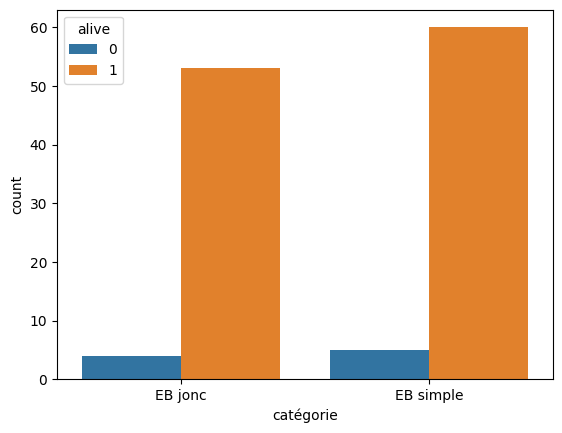

In [36]:
sns.countplot(data = patients_EB, x = "catégorie", hue="alive")

<Axes: xlabel='diagnostic', ylabel='count'>

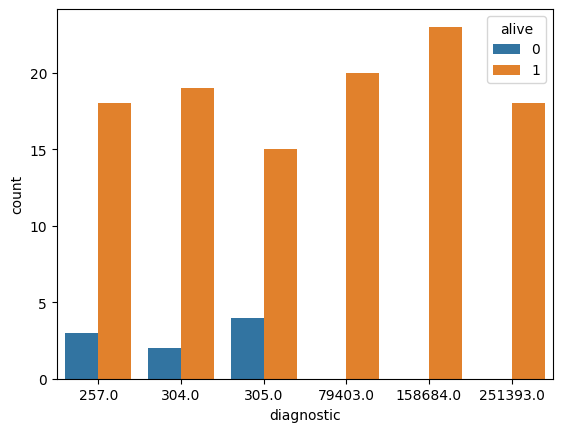

In [37]:
sns.countplot(data = patients_EB, x = "diagnostic", hue="alive")

In [38]:
pd.crosstab(patients_EB['catégorie'], patients_EB['alive'])

alive,0,1
catégorie,,
EB jonc,4,53
EB simple,5,60


In [39]:
pd.crosstab(patients_EB['sous-catégorie'], patients_EB['alive'])

alive,0,1
sous-catégorie,,
EB jonc atresie pylorique,0,18
EB jonc localise,0,20
EB jonc non identifié,4,15
EB simple atresie pylorique,0,23
EB simple dysotrophie,3,18
EB simple non identifié,2,19


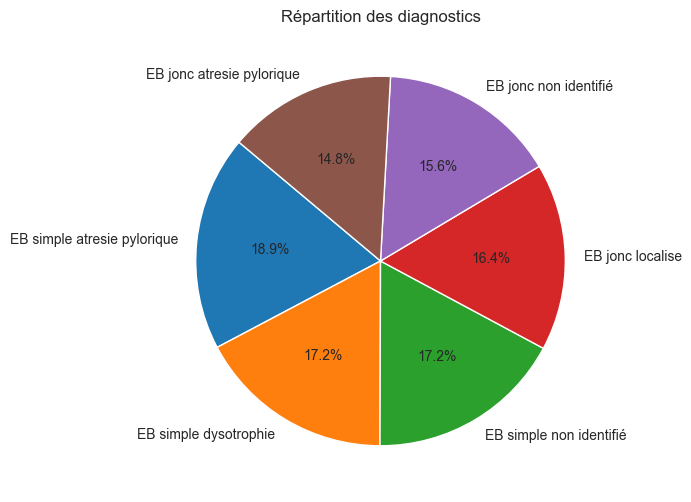

In [40]:
# Répartition des diagnostics

# Compter le nombre d'occurrences de chaque modalité
modalites_counts = patients_EB['sous-catégorie'].value_counts()

# Créer un diagramme circulaire avec Seaborn
sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6, 6))
plt.pie(modalites_counts, labels=modalites_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des diagnostics')
plt.show()

Généralement, on constate que c'est plutôt équilibré en termes répartition des diagnostics. On peut observer qu'il y a 32.8% de maladies qui n'ont pas pu identifier précisément.

In [41]:
# Test de corrélation entre deux variables
diagnostic_alive = pd.crosstab(patients_EB['diagnostic'], patients_EB['alive'])
chi2, p_value, dof, expected = chi2_contingency(diagnostic_alive)

# Afficher les résultats
print("Test du Chi carré d'indépendance - P-value :", p_value)

Test du Chi carré d'indépendance - P-value : 0.039639778857741344


On constate que la p-valeur est inférieur à 0.05 donc il existe une association significative entre les variables "diagnostic" et "alive". 

##### Analyse entre le niveau et le diagnostic

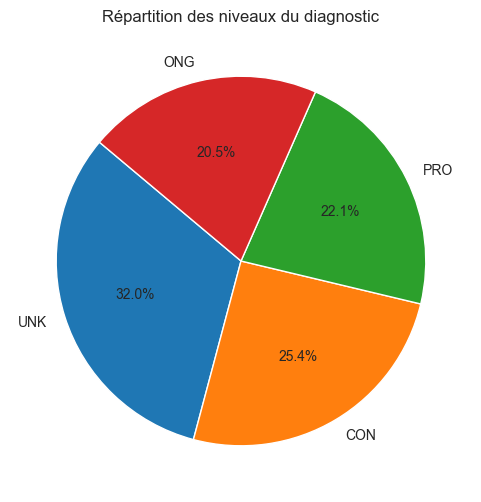

In [42]:
# Répartition des diagnostics

# Compter le nombre d'occurrences de chaque modalité
modalites_counts = patients_EB['level'].value_counts()

# Créer un diagramme circulaire avec Seaborn
sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6, 6))
plt.pie(modalites_counts, labels=modalites_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des niveaux du diagnostic')
plt.show()

<Axes: xlabel='diagnostic', ylabel='count'>

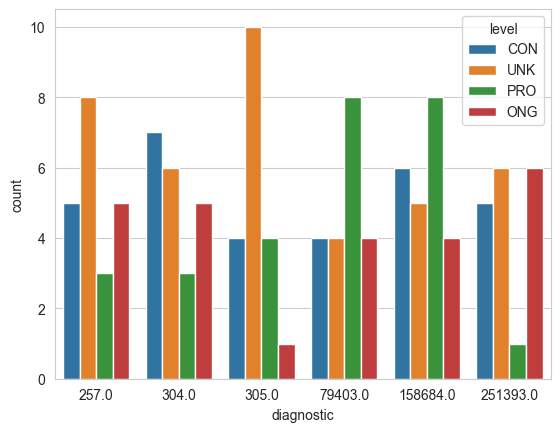

In [43]:
sns.countplot(data = patients_EB, x = "diagnostic", hue="level")

In [44]:
patients_EB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 184
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   birthyear          122 non-null    int64         
 1   housenum           122 non-null    float64       
 2   streetname         122 non-null    object        
 3   idmr               122 non-null    int64         
 4   alive              122 non-null    category      
 5   diagnostic         122 non-null    category      
 6   level              122 non-null    object        
 7   inclusion          122 non-null    datetime64[ns]
 8   last_activity      122 non-null    datetime64[ns]
 9   catégorie          122 non-null    object        
 10  sous-catégorie     122 non-null    object        
 11  durée              122 non-null    int64         
 12  age_inclusion      122 non-null    int64         
 13  age_last_activity  122 non-null    int64         
 14  adress         

In [45]:
# Test de corrélation entre deux variables
diagnostics_level = pd.crosstab(patients_EB['sous-catégorie'], patients_EB['level'])
chi2, p_value, dof, expected = chi2_contingency(diagnostics_level)

# Afficher les résultats
print("Test du Chi carré d'indépendance - P-value :", p_value)

Test du Chi carré d'indépendance - P-value : 0.2971068212037666


##### Analyse entre l'âge du patient et le diagnostic

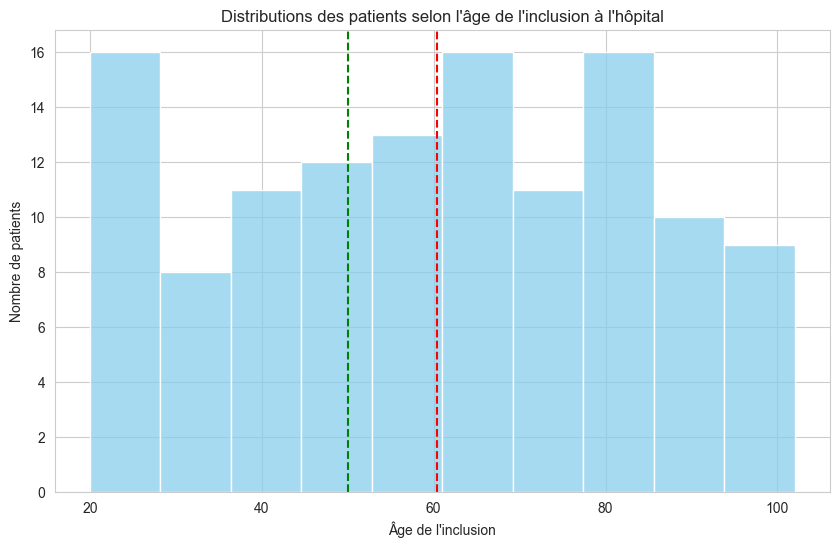

In [46]:
# Créer un histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=patients_EB, x='age_inclusion', bins=10, kde=False, color = "skyblue")
plt.title("Distributions des patients selon l'âge de l'inclusion à l'hôpital")
plt.xlabel("Âge de l'inclusion")
plt.ylabel('Nombre de patients')
# Ajouter une barre verticale au niveau de la moyenne
plt.axvline(x=patients_EB['age_inclusion'].mean(), color='red', linestyle='--')
# Ajouter une barre verticale au niveau de la valeur 50
plt.axvline(x=50, color='green', linestyle='--')
plt.show()

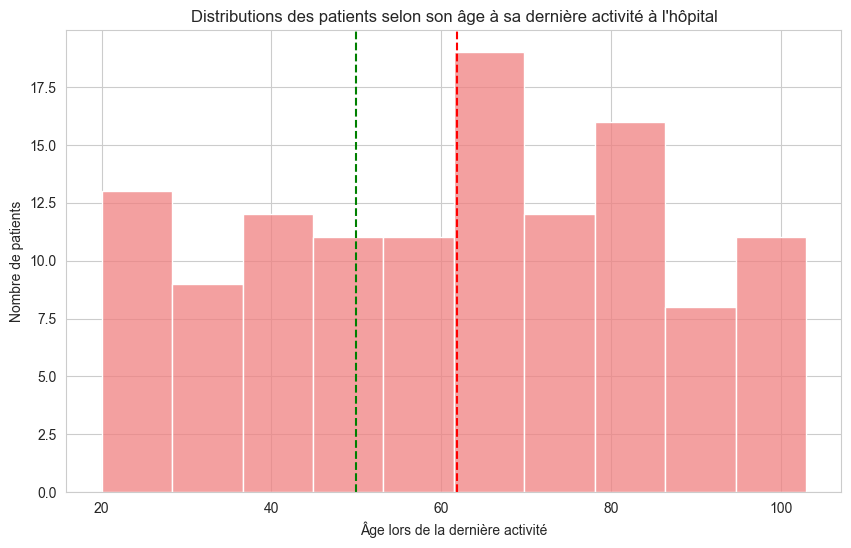

In [47]:
# Créer un histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=patients_EB, x='age_last_activity', bins=10, kde=False, color='lightcoral')
plt.title("Distributions des patients selon son âge à sa dernière activité à l'hôpital")
plt.xlabel("Âge lors de la dernière activité")
plt.ylabel('Nombre de patients')
# Ajouter une barre verticale au niveau de la moyenne
plt.axvline(x=patients_EB['age_last_activity'].mean(), color='red', linestyle='--')
# Ajouter une barre verticale au niveau de la valeur 50
plt.axvline(x=50, color='green', linestyle='--')
plt.show()

In [48]:
# Classer les patients si ils ont plus de 50 ans ou non lors de leurs dernières activités
patients_EB['last_activity_50'] = np.select(
    [patients_EB['age_last_activity'] < 50,
     patients_EB['age_last_activity'] >= 50],
    ['Moins de 50 ans', 'Plus de 50 ans']
)

# Classer les patients si ils ont plus de 50 ans ou non lors de leurs inclusions
patients_EB['inclusion_50'] = np.select(
    [patients_EB['age_inclusion'] < 50,
     patients_EB['age_inclusion'] >= 50],
    ['Moins de 50 ans', 'Plus de 50 ans']
)

In [49]:
print(pd.crosstab(patients_EB['sous-catégorie'], patients_EB['inclusion_50']))
print("\n")
print(pd.crosstab(patients_EB['sous-catégorie'], patients_EB['last_activity_50']))

inclusion_50                 Moins de 50 ans  Plus de 50 ans
sous-catégorie                                              
EB jonc atresie pylorique                  5              13
EB jonc localise                           7              13
EB jonc non identifié                      6              13
EB simple atresie pylorique                6              17
EB simple dysotrophie                      7              14
EB simple non identifié                    9              12


last_activity_50             Moins de 50 ans  Plus de 50 ans
sous-catégorie                                              
EB jonc atresie pylorique                  5              13
EB jonc localise                           6              14
EB jonc non identifié                      6              13
EB simple atresie pylorique                6              17
EB simple dysotrophie                      7              14
EB simple non identifié                    9              12


<Axes: xlabel='inclusion_50', ylabel='count'>

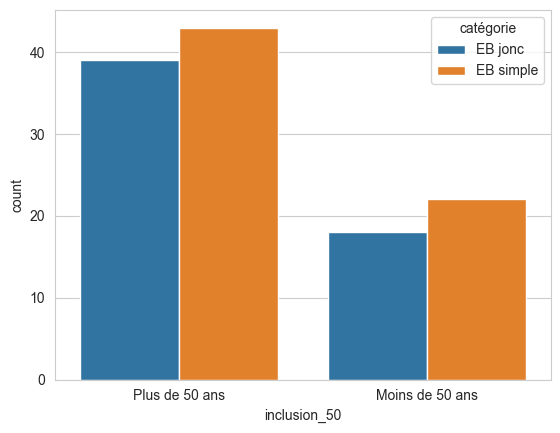

In [50]:
sns.countplot(data = patients_EB, x = "inclusion_50", hue="catégorie")

<Axes: xlabel='last_activity_50', ylabel='count'>

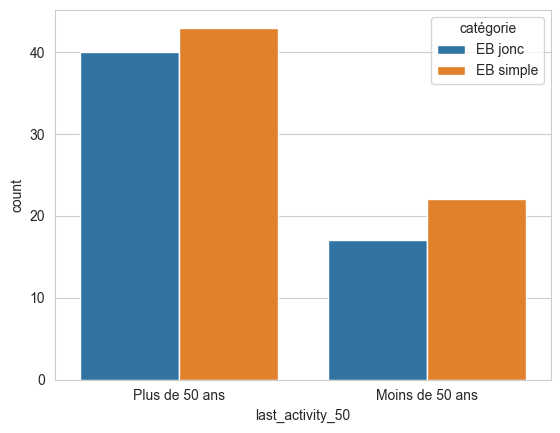

In [51]:
sns.countplot(data = patients_EB, x = "last_activity_50", hue="catégorie")

On constate que quel que soit le diagnostic, les patients agés de plus de 50 ans prédominent largement. Beaucoup plus de personnes agés de plus de 50 ans sont incluses à l'hôpital. Les analyses sur les dernières activités des patients montrent que personnes de plus de 50 ans sont encore nombreuses.

In [52]:
print("La durée moyenne des patients à l'hôpital est de", patients_EB.durée.mean(), "jours.")

La durée moyenne des patients à l'hôpital est de 551.9672131147541 jours.


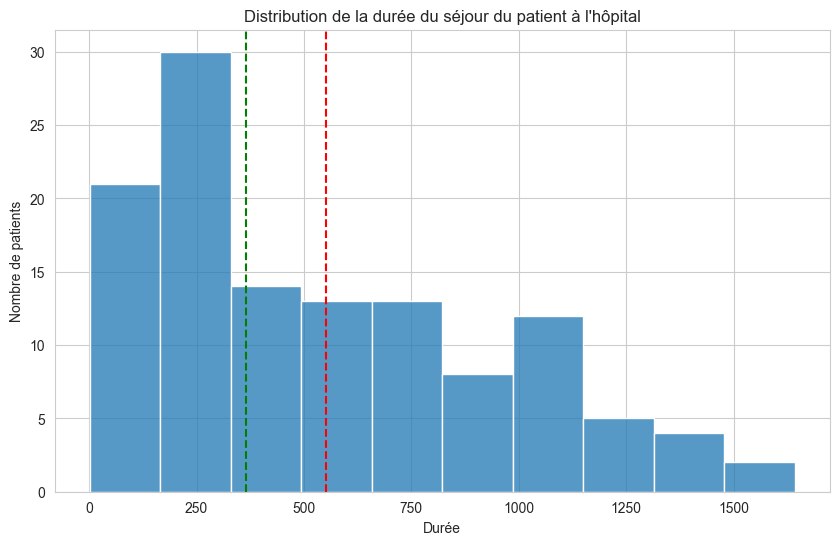

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data=patients_EB, x='durée', bins=10, kde=False)
plt.title("Distribution de la durée du séjour du patient à l'hôpital")
plt.xlabel("Durée")
plt.ylabel('Nombre de patients')
# Ajouter une barre verticale au niveau de la moyenne
plt.axvline(x=patients_EB["durée"].mean(), color='red', linestyle='--')
# Ajouter une barre verticale au niveau de la valeur 50
plt.axvline(x=365, color='green', linestyle='--')
plt.show()

À l'aide de l'histogramme, on constate que beaucoup de patients restent pendant moins d'un an à l'hôpital.

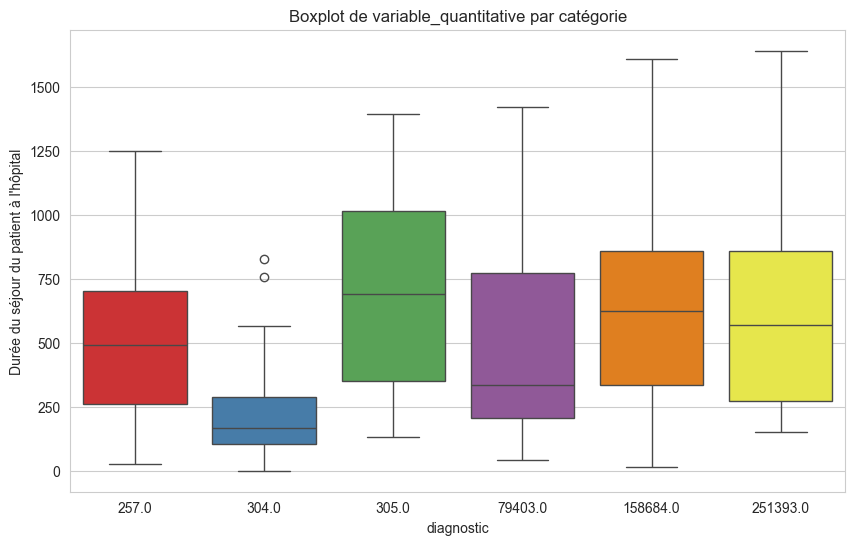

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=patients_EB, x='diagnostic', y='durée', palette='Set1')
plt.title('Boxplot de variable_quantitative par catégorie')
plt.ylabel("Durée du séjour du patient à l'hôpital")
plt.show()

        PC1       PC2    id_patient
0 -0.796740 -0.162658  3.263373e+09
1 -0.297504 -0.767367  3.433644e+09
2 -0.204798  0.277876           NaN
3 -0.599466 -0.965848  3.335356e+09
4 -0.863296 -0.038981           NaN


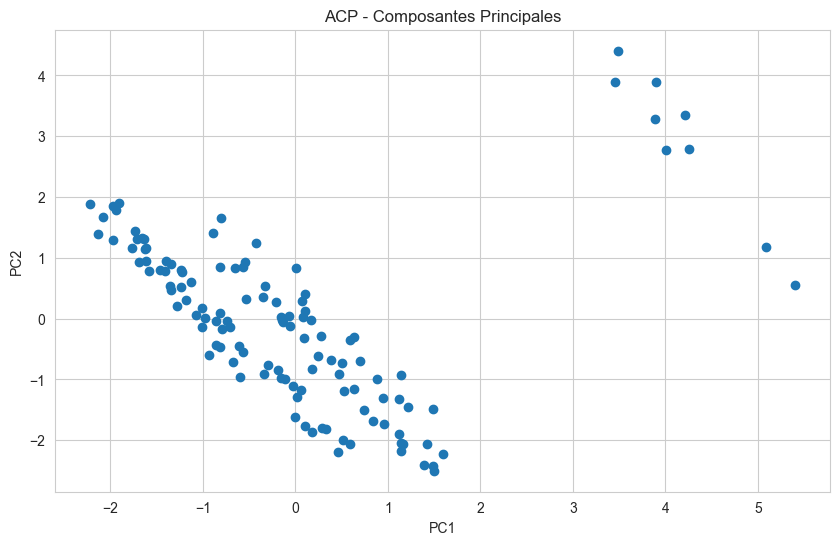

Valeurs propres : [2.34731032 2.04320241]
Pourcentage de variance expliquée par chaque PC : [0.21164273 0.18422317]


In [55]:
# Réalisation d'une ACP

# Prétraitement des données
## Transformer les variables catégorielles en variables indicatrices
patients_EB_ACP = patients_EB[["alive", "diagnostic", "age_last_activity", "age_inclusion", "durée"]]
patients_EB_ACP = pd.get_dummies(patients_EB_ACP)

# Mettre à l'échelle les variables quantitatives
scaler = StandardScaler()
patients_EB_ACP_scaled = scaler.fit_transform(patients_EB_ACP)

# ACP
pca = PCA(n_components=2)  # Vous pouvez modifier le nombre de composantes principales ici
principal_components = pca.fit_transform(patients_EB_ACP_scaled)

# Créer un DataFrame pour stocker les composantes principales
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Ajouter d'autres colonnes si nécessaire (par exemple, l'identifiant du patient)
principal_df['id_patient'] = patients_EB['idmr']

# Afficher les premières lignes du DataFrame des composantes principales
print(principal_df.head())

# Analyse des résultats
# Visualisation des PC
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ACP - Composantes Principales')
plt.show()

# Analyser les valeurs propres et les pourcentages de variance expliquée
print('Valeurs propres :', pca.explained_variance_)
print('Pourcentage de variance expliquée par chaque PC :', pca.explained_variance_ratio_)

#### Évaluer l'impact du type *EB* sur l'évolution de la concentration de plomb 

##### Analyse exploratoire sur la typologie de l'EB des patients suivis pour la concentration de plomb

In [56]:
patients_EB_plomb_simple = patients_EB_plomb.loc[patients_EB_plomb['catégorie'] == "EB simple"]
patients_EB_plomb_jonc = patients_EB_plomb.loc[patients_EB_plomb['catégorie'] == "EB jonc"]

In [87]:
patients_EB_plomb_simple[patients_EB_plomb_simple['sous-catégorie']=='EB simple dysotrophie'].shape

(15, 19)

In [122]:
print("Le nombre de patients traités pour l'EB simple est de ", 
      patients_EB_plomb_simple.shape[0], "parmi celle-ci ", 
      patients_EB_plomb_simple[patients_EB_plomb_simple['sous-catégorie']=='EB simple dysotrophie'].shape[0], 
      "sont atteints de l'EB simple dysotrophie et",
      patients_EB_plomb_simple[patients_EB_plomb_simple['sous-catégorie']=='EB simple atresie pylorique'].shape[0],
      "sont atteints de l'EB simple atresie pylorique.", 
      patients_EB_plomb_simple[patients_EB_plomb_simple['sous-catégorie']=='EB simple non identifié'].shape[0], 
      "patients n'ont pas pu être identifiés précisément.",  "\n"
     )

print("Le nombre de patients traités pour l'EB jonctionnelle est de ", 
      patients_EB_plomb_jonc.shape[0], "parmi celle-ci ", 
      patients_EB_plomb_jonc[patients_EB_plomb_jonc['sous-catégorie']=='EB jonc localise'].shape[0], 
      "sont atteints de l'EB jonctionnelle localisée et",
      patients_EB_plomb_jonc[patients_EB_plomb_jonc['sous-catégorie']=='EB jonc atresie pylorique'].shape[0],
      "sont atteints de l'EB jonctionnelle atresie pylorique.", 
      patients_EB_plomb_jonc[patients_EB_plomb_jonc['sous-catégorie']=='EB jonc non identifié'].shape[0],
      "patients n'ont pas pu être identifiés précisément.",  "\n"
     )

Le nombre de patients traités pour l'EB simple est de  39 parmi celle-ci  15 sont atteints de l'EB simple dysotrophie et 13 sont atteints de l'EB simple atresie pylorique. 11 patients n'ont pas pu être identifiés précisément. 

Le nombre de patients traités pour l'EB jonctionnelle est de  40 parmi celle-ci  14 sont atteints de l'EB jonctionnelle localisée et 12 sont atteints de l'EB jonctionnelle atresie pylorique. 14 patients n'ont pas pu être identifiés précisément. 



In [89]:
patients_EB_plomb['sous-catégorie'].unique()

array(['EB jonc atresie pylorique', 'EB simple dysotrophie',
       'EB simple atresie pylorique', 'EB jonc localise',
       'EB simple non identifié', 'EB jonc non identifié'], dtype=object)

##### Analyse exploratoire pour comprendre la distribution de la concentration de plomb pour chaque semaine selon chaque type de EB

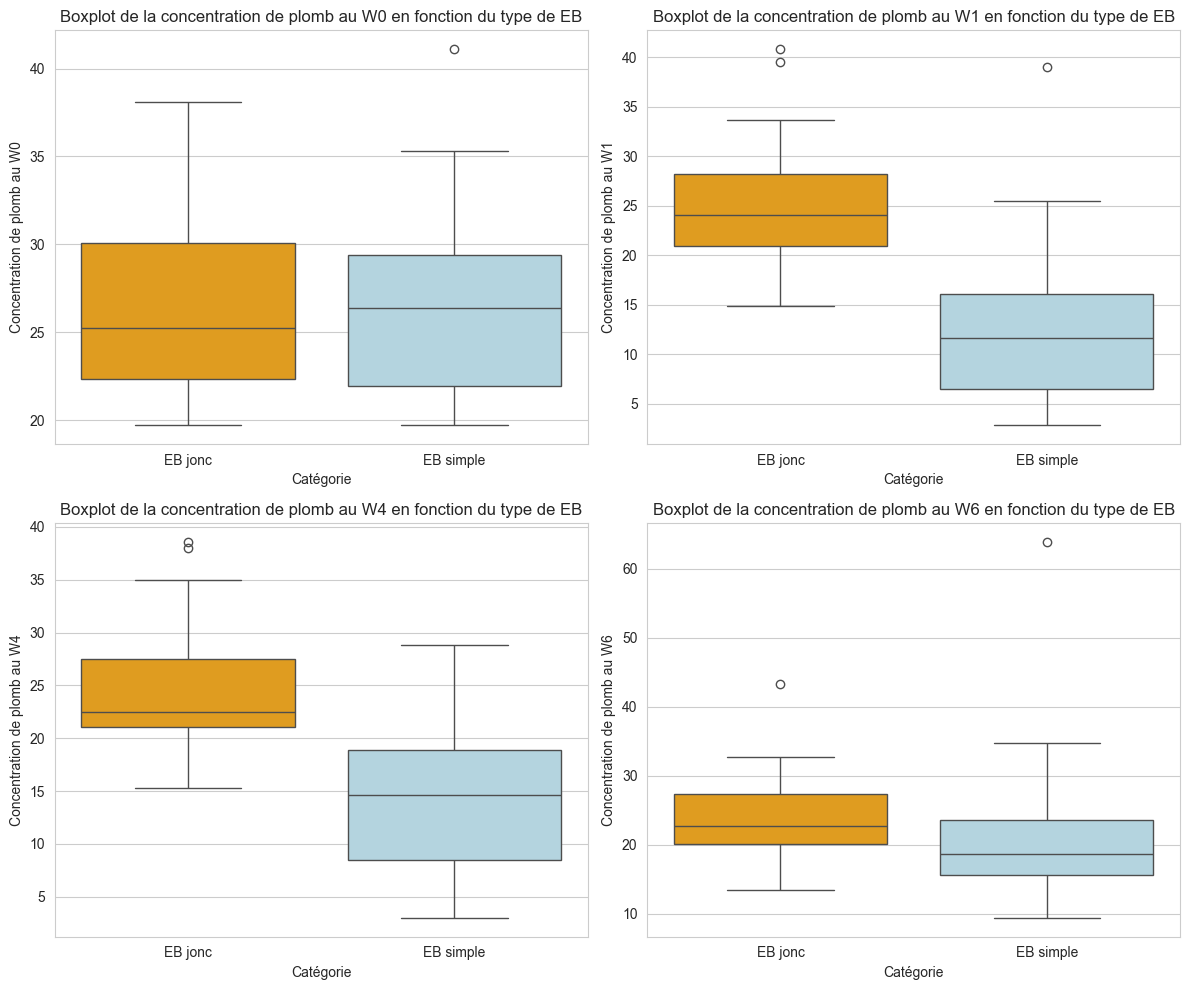

In [110]:
# Initialisation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Liste des semaines
weeks = ['W0', 'W1', 'W4', 'W6']

# Parcourir chaque semaine et créer un boxplot pour chaque type EB
for i, week in enumerate(weeks):
    row = i // 2  # Calculer le numéro de ligne
    col = i % 2   # Calculer le numéro de colonne
    
    # Créer le boxplot
    sns.boxplot(x='catégorie', y=week, data=patients_EB_plomb, palette={'EB jonc': 'orange', 'EB simple': 'lightblue'}, ax=axes[row, col])
    
    # Définir le titre et les labels
    axes[row, col].set_title(f'Boxplot de la concentration de plomb au {week} en fonction du type de EB')
    axes[row, col].set_xlabel('Catégorie')
    axes[row, col].set_ylabel(f'Concentration de plomb au {week}')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

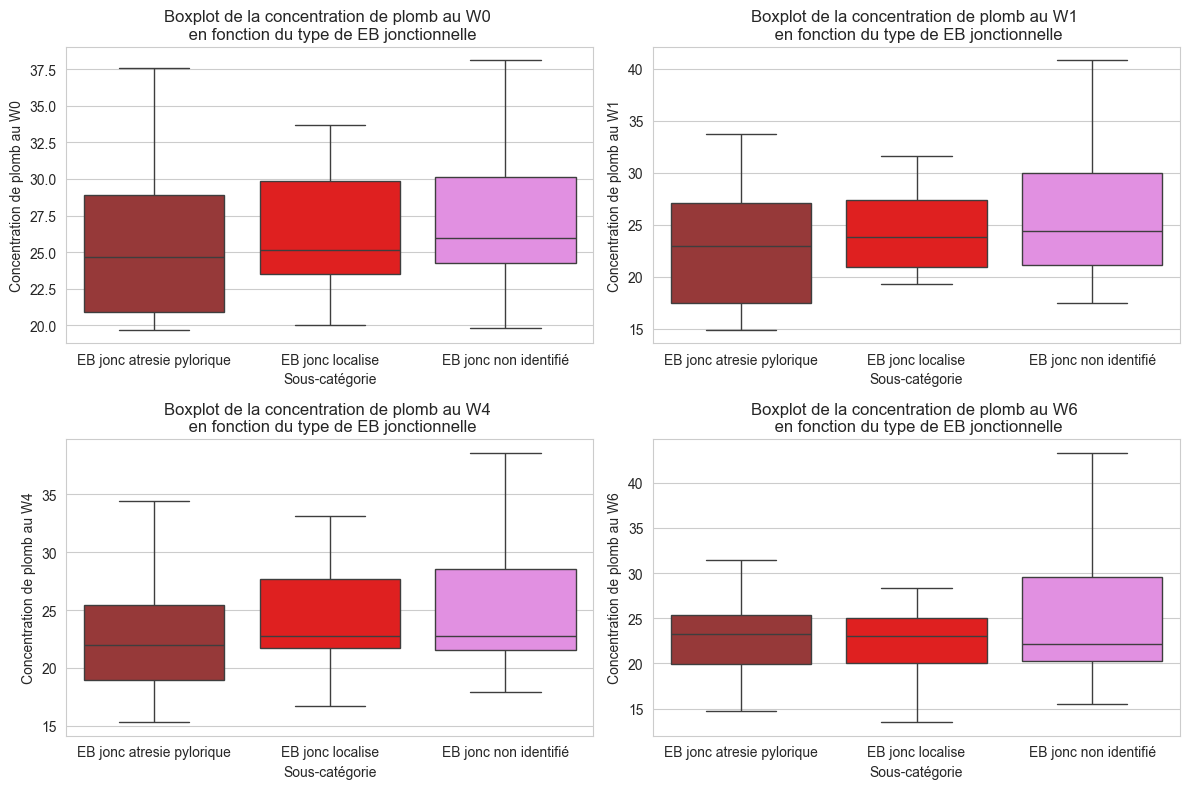

In [106]:
# Initialisation
plt.figure(figsize=(12, 8))

# Parcourir chaque semaine et créer un boxplot pour chaque sous-type de l'EB jonctionnelle
for i, week in enumerate(['W0', 'W1', 'W4', 'W6'], start=1):
    # Créer un subplot
    plt.subplot(2, 2, i)
    
    # Créer le boxplot
    sns.boxplot(x='sous-catégorie', y=week, data=patients_EB_plomb_jonc, 
                palette={'EB jonc atresie pylorique': 'brown', 
                         'EB jonc non identifié': 'violet',
                         'EB jonc localise': 'red'})
    
    # Ajouter un titre et des étiquettes d'axes
    plt.title(f'Boxplot de la concentration de plomb au {week} \n en fonction du type de EB jonctionnelle')
    plt.xlabel('Sous-catégorie')
    plt.ylabel(f'Concentration de plomb au {week}')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques
plt.show()

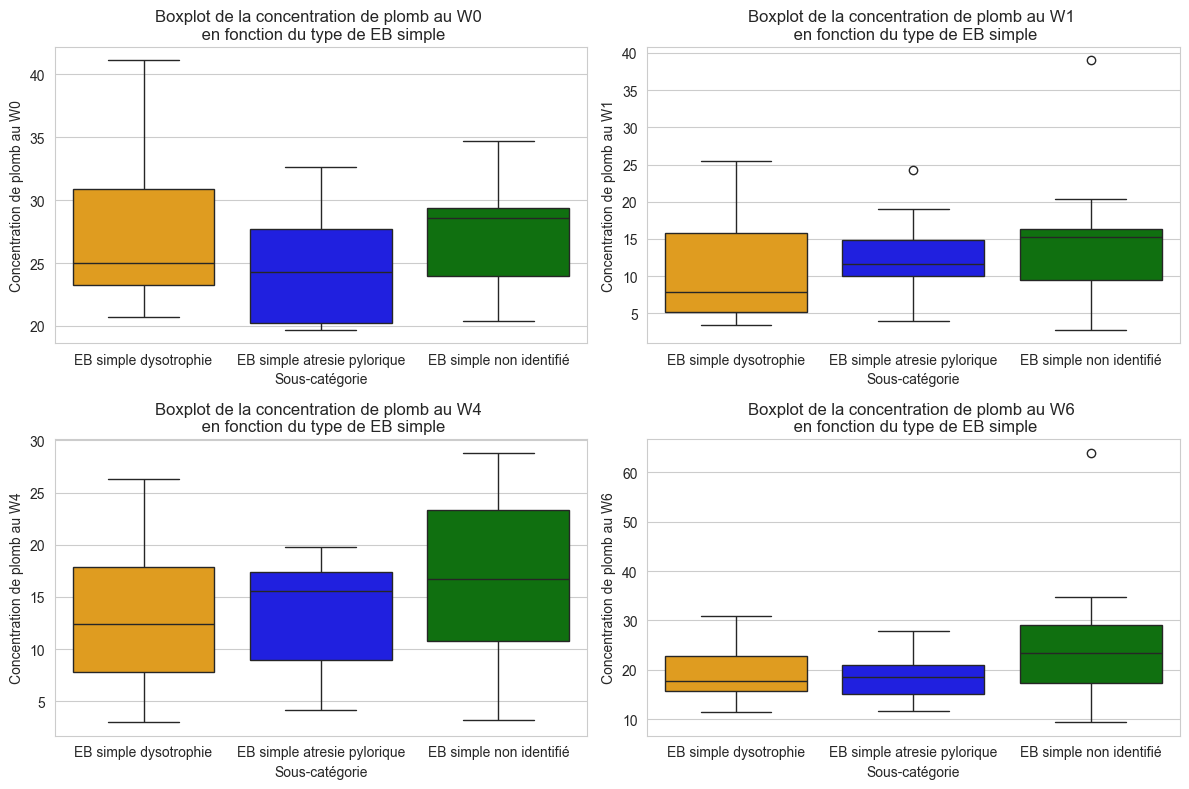

In [114]:
# Initialisation
plt.figure(figsize=(12, 8))

# Parcourir chaque semaine et créer un boxplot pour chaque sous-type de l'EB simple
for i, week in enumerate(['W0', 'W1', 'W4', 'W6'], start=1):
    # Créer un subplot
    plt.subplot(2, 2, i)
    
    # Créer le boxplot
    sns.boxplot(x='sous-catégorie', y=week, data=patients_EB_plomb_simple, 
                palette={'EB simple atresie pylorique': 'blue', 
                         'EB simple non identifié': 'green',
                         'EB simple dysotrophie': 'orange'})
    
    # Ajouter un titre et des étiquettes d'axes
    plt.title(f'Boxplot de la concentration de plomb au {week} \n en fonction du type de EB simple')
    plt.xlabel('Sous-catégorie')
    plt.ylabel(f'Concentration de plomb au {week}')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques
plt.show()

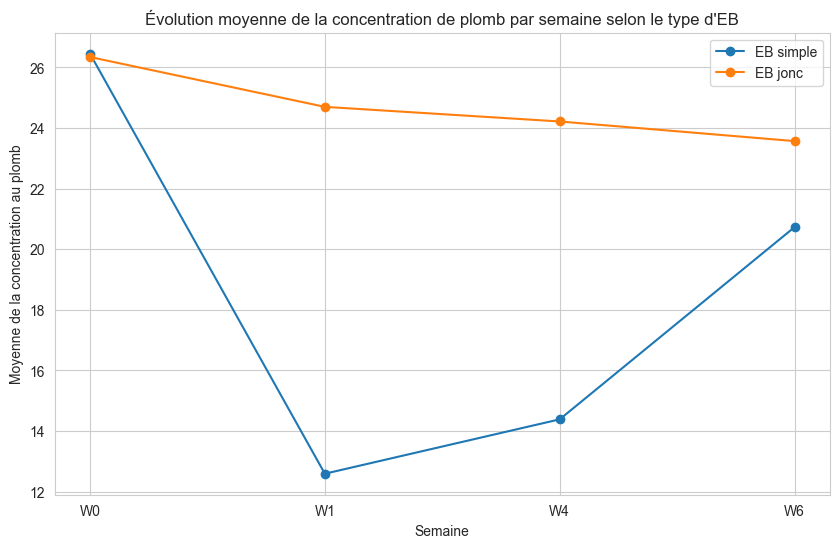

In [82]:
# calcul de la moyenne du concentration de plomb par semaine selon les catégorie
patients_EB_plomb_mean = patients_EB_plomb[['catégorie', 'W0', 'W1', 'W4','W6']].groupby(['catégorie'], as_index=False).mean()
# indexer une variable
patients_EB_plomb_mean = patients_EB_plomb_mean.set_index('catégorie', inplace=False)
# transposer le dataframe
patients_EB_plomb_mean = patients_EB_plomb_mean.transpose()

# Tracer le graphique pour visualisation l'évolution de la concentration en plomb selon les deux types de populations. 
plt.figure(figsize=(10, 6))

# Tracé de la moyenne pour EB jonc
plt.plot(patients_EB_plomb_mean.index, patients_EB_plomb_mean['EB simple'], marker='o', label='EB simple')

# Tracé de la moyenne pour EB simple
plt.plot(patients_EB_plomb_mean.index, patients_EB_plomb_mean['EB jonc'], marker='o', label='EB jonc')

# Ajouter des titres et des légendes
plt.title("Évolution moyenne de la concentration de plomb par semaine selon le type d'EB")
plt.xlabel("Semaine")
plt.ylabel("Moyenne de la concentration au plomb")
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

Généralement, la concentration du plomb dans le sang diminue pour les patients atteint de l'EB jonctionnelle au fil des semaines. 
Concernant les patients atteint de l'EB simple, la concentration de plomb connaît une forte baisse durant la première semaine avant d'augmenter considérablement.

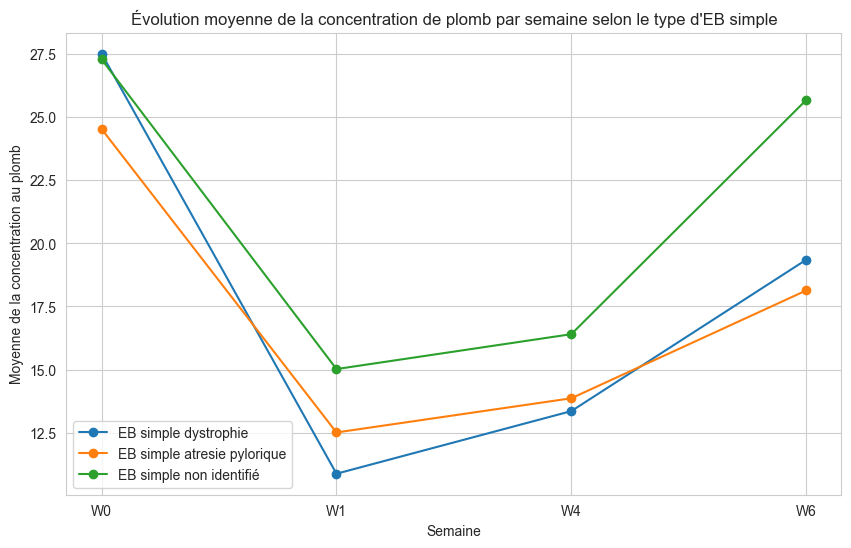

In [123]:
# calcul de la moyenne du concentration de plomb par semaine selon les catégorie
patients_EB_plomb_simple_mean = patients_EB_plomb_simple[['sous-catégorie', 'W0', 'W1', 'W4','W6']].groupby(['sous-catégorie'], as_index=False).mean()
# indexer une variable
patients_EB_plomb_simple_mean = patients_EB_plomb_simple_mean.set_index('sous-catégorie', inplace=False)
# transposer le dataframe
patients_EB_plomb_simple_mean = patients_EB_plomb_simple_mean.transpose()

# Tracer le graphique pour visualisation l'évolution de la concentration en plomb selon les deux types de populations. 
plt.figure(figsize=(10, 6))

# Tracé de la moyenne pour EB simple dystrophie
plt.plot(patients_EB_plomb_simple_mean.index, patients_EB_plomb_simple_mean['EB simple dysotrophie'], marker='o', label='EB simple dystrophie')

# Tracé de la moyenne pour EB simple atresie pylorique
plt.plot(patients_EB_plomb_simple_mean.index, patients_EB_plomb_simple_mean['EB simple atresie pylorique'], marker='o', label='EB simple atresie pylorique')

# Tracé de la moyenne pour EB simple atresie pylorique
plt.plot(patients_EB_plomb_simple_mean.index, patients_EB_plomb_simple_mean['EB simple non identifié'], marker='o', label='EB simple non identifié')

# Ajouter des titres et des légendes
plt.title("Évolution moyenne de la concentration de plomb par semaine selon le type d'EB simple")
plt.xlabel("Semaine")
plt.ylabel("Moyenne de la concentration au plomb")
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

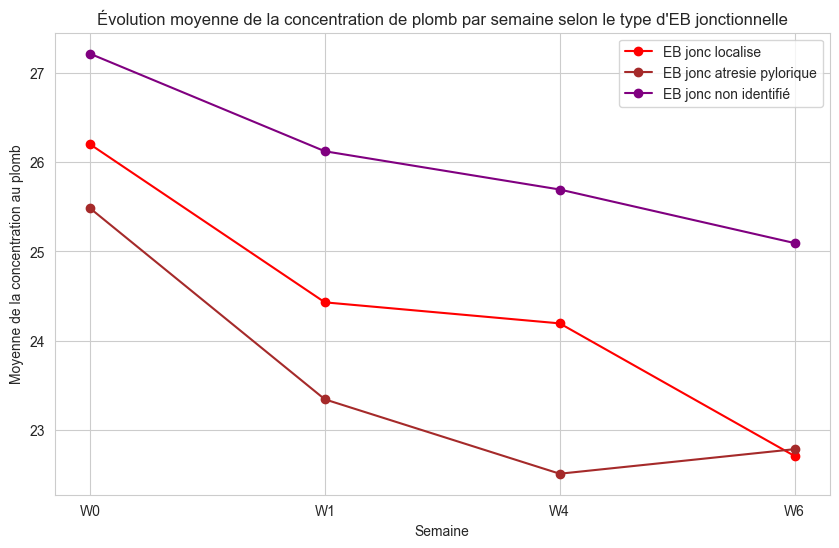

In [125]:
# calcul de la moyenne du concentration de plomb par semaine selon les catégorie
patients_EB_plomb_jonc_mean = patients_EB_plomb_jonc[['sous-catégorie', 'W0', 'W1', 'W4','W6']].groupby(['sous-catégorie'], as_index=False).mean()
# indexer une variable
patients_EB_plomb_jonc_mean = patients_EB_plomb_jonc_mean.set_index('sous-catégorie', inplace=False)
# transposer le dataframe
patients_EB_plomb_jonc_mean = patients_EB_plomb_jonc_mean.transpose()

# Tracer le graphique pour visualisation l'évolution de la concentration en plomb selon les deux types de populations. 
plt.figure(figsize=(10, 6))

# Tracé de la moyenne pour EB simple dystrophie
plt.plot(patients_EB_plomb_jonc_mean.index, patients_EB_plomb_jonc_mean['EB jonc localise'], marker='o', label='EB jonc localise', color='red')

# Tracé de la moyenne pour EB simple atresie pylorique
plt.plot(patients_EB_plomb_jonc_mean.index, patients_EB_plomb_jonc_mean['EB jonc atresie pylorique'], marker='o', label='EB jonc atresie pylorique', color='brown')

# Tracé de la moyenne pour EB simple atresie pylorique
plt.plot(patients_EB_plomb_jonc_mean.index, patients_EB_plomb_jonc_mean['EB jonc non identifié'], marker='o', label='EB jonc non identifié', color='purple')

# Ajouter des titres et des légendes
plt.title("Évolution moyenne de la concentration de plomb par semaine selon le type d'EB jonctionnelle")
plt.xlabel("Semaine")
plt.ylabel("Moyenne de la concentration au plomb")
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

In [121]:
patients_EB_plomb_jonc_mean

sous-catégorie,EB jonc atresie pylorique,EB jonc localise,EB jonc non identifié
W0,25.483333,26.200000,27.214286
W1,23.341667,24.428571,26.121429
W4,22.508333,24.192857,25.692857
W6,22.783333,22.707143,25.092857


In [138]:
patients_EB_plomb[['idmr', 'level', 'catégorie', 'W0', 'W1', 'W4', 'W6']]

,idmr,level,catégorie,W0,W1,W4,W6
1,3433643965,UNK,EB jonc,28.5,32.6,27.5,22.8
3,3335356165,PRO,EB simple,34.0,10.7,12.6,21.2
4,6133616339,UNK,EB simple,19.7,13.2,14.6,11.6
6,6661373731,UNK,EB jonc,32.5,25.1,27.8,27.3
7,3732643062,ONG,EB simple,20.2,17.5,17.4,18.6
...,...,...,...,...,...,...,...
113,3230333231,ONG,EB simple,26.4,15.3,24.6,32.4
114,3334646636,UNK,EB jonc,26.2,26.8,25.3,24.8
115,3936396364,PRO,EB jonc,33.7,31.6,28.5,25.1
117,3538396363,UNK,EB simple,29.1,16.8,15.1,18.8


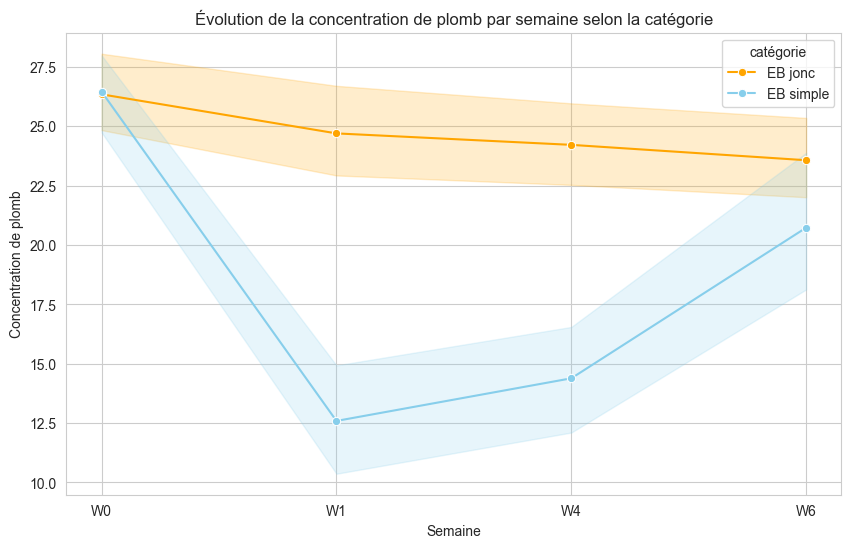

In [140]:
# Convertir les données en format long pour faciliter la visualisation
patients_EB_plomb_long = patients_EB_plomb[['idmr', 'level', 'catégorie', 'W0', 'W1', 'W4', 'W6']].melt(id_vars=['idmr', 'level', 'catégorie'], var_name='Semaine', value_name='Concentration de plomb')

# Tracer le graphique avec seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=patients_EB_plomb_long, x='Semaine', y='Concentration de plomb', hue='catégorie', marker='o', palette={'EB jonc': 'orange', 'EB simple': 'skyblue'})
plt.title("Évolution de la concentration de plomb par semaine selon la catégorie")
plt.xlabel("Semaine")
plt.ylabel("Concentration de plomb")
plt.grid(True)
plt.show()